Importing Modules

In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import numpy as np
import argparse
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
import sys, importlib as impL
sys.path.insert(1,'/home/wsubuntu/GitHub/keyhandshapediscovery')
import helperFuncs as funcH
import pandas as pd

EXPERIMENT_ID = 25
LOSS_TYPE='cre'
LOSS_REDUCTION='mean' #'sum','batchmean'
SIGMOID_ACT=True
MSE_PLUS_MINUS='+'
APPLY_SPARSITY_TO='bottleneck' #all

In [2]:
def calc_bottleneck_acc(bottleneck_vec, lab_vec):
    pred_vec = np.argmax(bottleneck_vec.T, axis=0).T.squeeze()
    centroid_info_pdf = funcH.get_cluster_centroids(bottleneck_vec, pred_vec, kluster_centers=None, verbose=0)
    _confMat_preds, kluster2Classes, kr_pdf, weightedPurity, cnmxh_perc = funcH.countPredictionsForConfusionMat(lab_vec, pred_vec, centroid_info_pdf=centroid_info_pdf, labelNames=None)
    sampleCount = np.sum(np.sum(_confMat_preds))
    acc = 100 * np.sum(np.diag(_confMat_preds)) / sampleCount
    bmx, bmn = np.max(bottleneck_vec), np.min(bottleneck_vec)
    return acc, bmx, bmn

funcH.setPandasDisplayOpts()

Constructing the Argument Parsers

In [3]:
#ap = argparse.ArgumentParser()
#ap.add_argument('-e', '--epochs', type=int, default=10, help='number of epochs to train our network for')
#ap.add_argument('-l', '--reg_param', type=float, default=0.001, help='regularization parameter `lambda`')
#ap.add_argument('-sc', '--add_sparse', type=str, default='yes', help='whether to add sparsity contraint or not')
#args = vars(ap.parse_args())
epochs = 100  # args['epochs']
reg_param = 0.01  # args['reg_param']
add_sparsity = 'yes'  # args['add_sparse']
learning_rate = 1e-4
batch_size = 32
print(f"Add sparsity regularization: {add_sparsity}")

Add sparsity regularization: yes


here I will change the data loader per my need

In [4]:
# get the computation device
def get_device():
    return 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cpu


In [5]:
# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

FOLDERS = {
    "data": '/media/wsubuntu/SSD_Data/DataPath',
    "experiment": '/media/wsubuntu/SSD_Data/vaesae_experiments/sparse_torch_ae_ws_' + str(EXPERIMENT_ID).zfill(3),
}
FOLDERS["model_save"] = os.path.join(FOLDERS["experiment"], "model")
FOLDERS["decoder_image_path_tr"] = os.path.join(FOLDERS["experiment"], "output_images_tr")
FOLDERS["decoder_image_path_va"] = os.path.join(FOLDERS["experiment"], "output_images_va")
funcH.createDirIfNotExist(FOLDERS["model_save"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_tr"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_va"])

trainset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=True, 
    download=True,
    transform=transform
)
testset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=False,
    download=True,
    transform=transform
)
 
# trainloader
trainloader = DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True
)
#testloader
testloader = DataLoader(
    testset, 
    batch_size=batch_size, 
    shuffle=False
)

In [6]:
# define the autoencoder model
class SparseAutoencoder(nn.Module):
    def __init__(self, loss_type):
        super(SparseAutoencoder, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
        
        self.loss_type=loss_type
        self.device = get_device()

    def encode(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        bottleneck = F.relu(self.enc5(x))  
        return bottleneck
        
    def decode(self, bottleneck):
        # decoding
        x = F.relu(self.dec1(bottleneck))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x)) 
        return x
        
    def forward(self, x):
        bottleneck = self.encode(x)
        x = self.decode(bottleneck)
        return x, bottleneck

model = SparseAutoencoder(loss_type=LOSS_TYPE).to(device)

In [7]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# get the layers as a list
model_children = list(model.children())
[print(i) for i in model_children]

Linear(in_features=784, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=16, bias=True)
Linear(in_features=16, out_features=32, bias=True)
Linear(in_features=32, out_features=64, bias=True)
Linear(in_features=64, out_features=128, bias=True)
Linear(in_features=128, out_features=256, bias=True)
Linear(in_features=256, out_features=784, bias=True)


[None, None, None, None, None, None, None, None, None, None]

In [9]:
def loss_l1(bottleneck):
    return torch.mean(torch.abs(bottleneck))

def loss_l2(bottleneck):
    return torch.mean(torch.pow(bottleneck, torch.tensor(2.0).to(device))).sqrt()

def kl_divergence(bottleneck, reduction):
    rho = 0.05
    bottleneck = torch.mean(torch.sigmoid(bottleneck), 1)  # sigmoid because we need the probability distributions
    rho = torch.tensor([rho] * len(bottleneck)).to(device)
    loss_ret_1 = torch.nn.functional.kl_div(bottleneck, rho, reduction=reduction)
    # torch.sum(rho * torch.log(rho / bottleneck) + (1 - rho) * torch.log((1 - rho) / (1 - bottleneck)))
    return loss_ret_1

def loss_crossentropy(bottleneck, sigmoidAct, reduction):
    loss_fun = torch.nn.CrossEntropyLoss(reduction=reduction)
    if sigmoidAct:
        bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
    _, preds = torch.max(bt, 1)
    loss_ret_1 = loss_fun(bt, preds)    
    return loss_ret_1

In [10]:
# define the sparse loss function
def sparse_loss(autoencoder, images, print_info, loss_type):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))
        #if print_info:
            #print(i, ' shape=', values.shape)
        if loss_type=='l1':
            loss += loss_l1(values)
        if loss_type=='l2':
            loss += loss_l2(values)
        if loss_type=='kl':
            loss += kl_divergence(values, reduction=LOSS_REDUCTION)
        if loss_type=='cre':
            loss += loss_crossentropy(values, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION)
        if print_info:
            print(loss_type,loss)
    return loss

def sparse_loss_bottleneck(bottleneck, print_info, loss_type):
    loss = 0
    #if print_info:
        #print(i, ' shape=', values.shape)
    if loss_type=='l1':
        loss += loss_l1(bottleneck)
    if loss_type=='l2':
        loss += loss_l2(bottleneck)
    if loss_type=='kl':
        loss += kl_divergence(bottleneck, reduction=LOSS_REDUCTION)
    if loss_type=='cre':
        loss += loss_crossentropy(bottleneck, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION)
    if print_info:
        print(loss_type,loss)
    return loss

In [11]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

# define the training function
def fit(model, dataloader, epoch, print_losses_fit):
    print('TrEpoch({:03d}) - '.format(epoch), end='')
    model.train()
    running_loss = 0.0
    
    lab_vec = []
    bottleneck_vec = []
    sparsity_loss_sum = 0
    mse_sum = 0
       
    for data in dataloader:
        img, lb = data
        lab_vec.append(lb)
        
        img = img.to(device)
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        outputs, bottleneck = model(img)
        bottleneck_vec.append(bottleneck)
        mse_loss = criterion(outputs, img)
        mse_sum += mse_loss.item()
        #if print_losses_fit:
            #print("mse_loss:", mse_loss.to('cpu'))
            #print("bottleneck:", bottleneck.to('cpu'))
        if add_sparsity == 'yes':
            if APPLY_SPARSITY_TO=='all':
                sp_loss = sparse_loss(model, img, print_losses_fit, model.loss_type)
            elif APPLY_SPARSITY_TO=='bottleneck': #all
                sp_loss = sparse_loss_bottleneck(bottleneck, print_losses_fit, model.loss_type)
            else:
                os.exit(4)
                
            sparsity_loss_sum += sp_loss.item()
            
            # add the sparsity penalty
            if print_losses_fit:
                print("sp_loss:", sparsity_loss_sum)
                
            if MSE_PLUS_MINUS=='-':
                loss = mse_loss - reg_param * sp_loss
            elif MSE_PLUS_MINUS=='+':
                loss = mse_loss + reg_param * sp_loss
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print_losses_fit = False
    
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)
    #print("tr bottleneck accuracy=", acc, ", max=", bmx, ", min=", bmn, ", sparsity_loss_sum=", sparsity_loss_sum)
  
    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, mse_sum, sparsity_loss_sum, running_loss]]), columns=['acc','bmx','bmn','mse','spr','run'])
    #print(df.iloc[0]['mse']) #'acc','bmx','bmn','mse','spr','run'
    print("\n",result_df)
    if epoch % 2 == 0:
        difn = os.path.join(FOLDERS["decoder_image_path_tr"], "train"+str(epoch).zfill(3)+".png")
        save_decoded_image(outputs.cpu().data, difn)
    return result_df

In [12]:
# define the validation function
def validate(model, dataloader, epoch, print_losses_fit):
    print('ValEpoch({:03d}) - '.format(epoch), end='')
    model.eval()
    running_loss = 0.0
    lab_vec = []
    bottleneck_vec = []
    with torch.no_grad():
        for data in dataloader:
            img, lb = data
            lab_vec.append(lb)
            img = img.to(device)
            img = img.view(img.size(0), -1)
            outputs, bottleneck = model(img)
            bottleneck_vec.append(bottleneck)
            loss = criterion(outputs, img)
            running_loss += loss.item()
    # save the reconstructed images every 5 epochs
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)

    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, running_loss]]), columns=['acc','bmx','bmn','run'])
    print("\n",result_df)
    
    if epoch % 2 == 0:
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        difn = os.path.join(FOLDERS["decoder_image_path_va"], "reconstruction"+str(epoch).zfill(3)+".png")
        save_image(outputs, difn)
    return result_df

In [13]:
# train and validate the autoencoder neural network
start = time.time()
print_losses_fit = True

train_loss = []
trn_spars_loss = []
trn_bot_acc = []
val_loss = []
val_bot_acc = []

result_df_tr_all = pd.DataFrame(columns=['acc','bmx','bmn','mse','spr','run'])
result_df_va_all = pd.DataFrame(columns=['acc','bmx','bmn','run'])

print("stae_ws05 :: ")
print("EXPERIMENT_ID: ", EXPERIMENT_ID)
print("LOSS_TYPE : ", LOSS_TYPE)
print("LOSS_REDUCTION : ", LOSS_REDUCTION)
print("SIGMOID_ACT : ", SIGMOID_ACT)
print("APPLY_SPARSITY_TO : ", APPLY_SPARSITY_TO)
print("total loss = mse_loss " + MSE_PLUS_MINUS + " reg_param("+ str(reg_param) +") * sp_loss")

for epoch in range(epochs):
    print(f"*****\n Epoch {epoch} of {epochs}")
    result_df_tr = fit(model, trainloader, epoch, print_losses_fit)
    result_df_va = validate(model, testloader, epoch, print_losses_fit)
    print_losses_fit = epoch%5==0 and epoch>0
    result_df_tr_all = result_df_tr_all.append(result_df_tr, ignore_index=True)
    result_df_va_all = result_df_va_all.append(result_df_va, ignore_index=True)
    
end = time.time()
 
print(f"{(end-start)/60:.3} minutes")
# save the trained model

mofn = os.path.join(FOLDERS["model_save"], "sparse_ae_"+str(epoch).zfill(3)+".pth")
torch.save(model.state_dict(), mofn)

stae_ws05 :: 
EXPERIMENT_ID:  25
LOSS_TYPE :  cre
LOSS_REDUCTION :  mean
SIGMOID_ACT :  True
APPLY_SPARSITY_TO :  bottleneck
total loss = mse_loss + reg_param(0.01) * sp_loss
*****
 Epoch 0 of 100
TrEpoch(000) - cre tensor(2.7421, grad_fn=<AddBackward0>)
sp_loss: 2.74214506149292

     acc     bmx  bmn      mse       spr      run
0  10.0  43.575  0.0  155.603  4471.308  200.316
ValEpoch(000) - 
     acc     bmx  bmn     run
0  10.0  44.773  0.0  19.181
*****
 Epoch 1 of 100
TrEpoch(001) - 
       acc     bmx  bmn      mse       spr      run
0  10.045  48.206  0.0  108.393  4407.743  152.471
ValEpoch(001) - 
      acc     bmx  bmn     run
0  10.19  48.212  0.0  17.276
*****
 Epoch 2 of 100
TrEpoch(002) - 
      acc     bmx  bmn      mse       spr      run
0  10.61  51.402  0.0  101.392  4406.598  145.458
ValEpoch(002) - 
      acc     bmx  bmn     run
0  10.38  50.366  0.0  16.466
*****
 Epoch 3 of 100
TrEpoch(003) - 
       acc     bmx  bmn     mse       spr      run
0  11.453  50.279 

TrEpoch(035) - 
       acc     bmx  bmn     mse       spr     run
0  10.877  26.051  0.0  49.304  4408.429  93.388
ValEpoch(035) - 
     acc     bmx  bmn    run
0  10.9  25.059  0.0  8.207
*****
 Epoch 36 of 100
TrEpoch(036) - cre tensor(2.3477, grad_fn=<AddBackward0>)
sp_loss: 2.3476955890655518

       acc     bmx  bmn     mse       spr     run
0  10.708  25.609  0.0  48.782  4407.704  92.859
ValEpoch(036) - 
      acc     bmx  bmn    run
0  10.86  24.355  0.0  8.231
*****
 Epoch 37 of 100
TrEpoch(037) - 
       acc     bmx  bmn     mse       spr     run
0  10.692  25.303  0.0  48.646  4406.914  92.715
ValEpoch(037) - 
      acc     bmx  bmn    run
0  10.86  24.229  0.0  8.173
*****
 Epoch 38 of 100
TrEpoch(038) - 
      acc     bmx  bmn    mse       spr     run
0  10.77  24.779  0.0  48.55  4406.239  92.612
ValEpoch(038) - 
      acc     bmx  bmn    run
0  10.84  23.592  0.0  8.224
*****
 Epoch 39 of 100
TrEpoch(039) - 
       acc     bmx  bmn    mse       spr     run
0  10.703  24.


     acc     bmx  bmn     mse      spr     run
0  10.0  19.453  0.0  44.648  4392.56  88.574
ValEpoch(071) - 
     acc     bmx  bmn    run
0  10.0  19.007  0.0  7.594
*****
 Epoch 72 of 100
TrEpoch(072) - 
     acc     bmx  bmn     mse       spr     run
0  10.0  19.488  0.0  44.597  4392.498  88.522
ValEpoch(072) - 
     acc     bmx  bmn    run
0  10.0  19.151  0.0  7.532
*****
 Epoch 73 of 100
TrEpoch(073) - 
     acc     bmx  bmn     mse       spr     run
0  10.0  19.336  0.0  43.561  4392.578  87.486
ValEpoch(073) - 
     acc    bmx  bmn   run
0  10.0  18.98  0.0  7.39
*****
 Epoch 74 of 100
TrEpoch(074) - 
     acc     bmx  bmn     mse       spr     run
0  10.0  19.304  0.0  43.523  4392.476  87.448
ValEpoch(074) - 
     acc     bmx  bmn    run
0  10.0  18.869  0.0  7.404
*****
 Epoch 75 of 100
TrEpoch(075) - 
     acc     bmx  bmn     mse       spr     run
0  10.0  19.305  0.0  43.458  4392.518  87.384
ValEpoch(075) - 
     acc     bmx  bmn    run
0  10.0  18.659  0.0  7.392
****

In [14]:
print(result_df_tr_all)

       acc     bmx  bmn      mse       spr      run
0   10.000  43.575  0.0  155.603  4471.308  200.316
1   10.045  48.206  0.0  108.393  4407.743  152.471
2   10.610  51.402  0.0  101.392  4406.598  145.458
3   11.453  50.279  0.0   95.525  4417.629  139.702
4   12.613  48.370  0.0   88.050  4428.058  132.330
5   10.677  48.013  0.0   80.748  4430.513  125.053
6   12.870  48.338  0.0   77.674  4427.968  121.954
7   13.295  48.300  0.0   74.108  4426.363  118.372
8   13.708  47.913  0.0   72.871  4425.065  117.122
9   13.778  46.374  0.0   71.349  4423.876  115.587
10  13.875  45.324  0.0   68.630  4422.636  112.856
11  13.850  44.462  0.0   67.494  4421.507  111.709
12  13.762  42.548  0.0   65.344  4420.710  109.551
13  13.662  41.959  0.0   64.262  4420.232  108.465
14  13.037  40.859  0.0   63.348  4419.658  107.545
15  12.242  38.819  0.0   62.329  4419.305  106.522
16  11.805  38.047  0.0   61.636  4419.493  105.831
17  11.533  37.297  0.0   60.431  4422.637  104.658
18  11.415  

In [15]:
print(result_df_va_all)

      acc     bmx  bmn     run
0   10.00  44.773  0.0  19.181
1   10.19  48.212  0.0  17.276
2   10.38  50.366  0.0  16.466
3   11.92  46.625  0.0  15.219
4   12.61  46.266  0.0  13.939
5   12.98  46.914  0.0  13.139
6   12.90  47.478  0.0  12.742
7   10.75  46.623  0.0  12.229
8   10.76  46.322  0.0  12.106
9   10.78  44.820  0.0  11.706
10  10.87  43.371  0.0  11.379
11  10.89  41.881  0.0  11.170
12  10.90  40.785  0.0  10.887
13  13.63  39.724  0.0  10.682
14  12.64  38.063  0.0  10.490
15  12.12  37.495  0.0  10.422
16  11.78  36.213  0.0  10.277
17  11.28  36.192  0.0   9.986
18  11.47  35.656  0.0   9.794
19  11.48  34.988  0.0   9.626
20  11.47  34.229  0.0   9.515
21  11.57  33.197  0.0   9.506
22  11.50  32.562  0.0   9.227
23  11.37  31.895  0.0   8.991
24  11.54  31.282  0.0   8.966
25  11.24  30.360  0.0   8.829
26  11.38  29.048  0.0   8.773
27  11.17  28.866  0.0   8.663
28  11.14  28.356  0.0   8.614
29  11.16  27.447  0.0   8.561
30  11.24  26.760  0.0   8.553
31  10.9

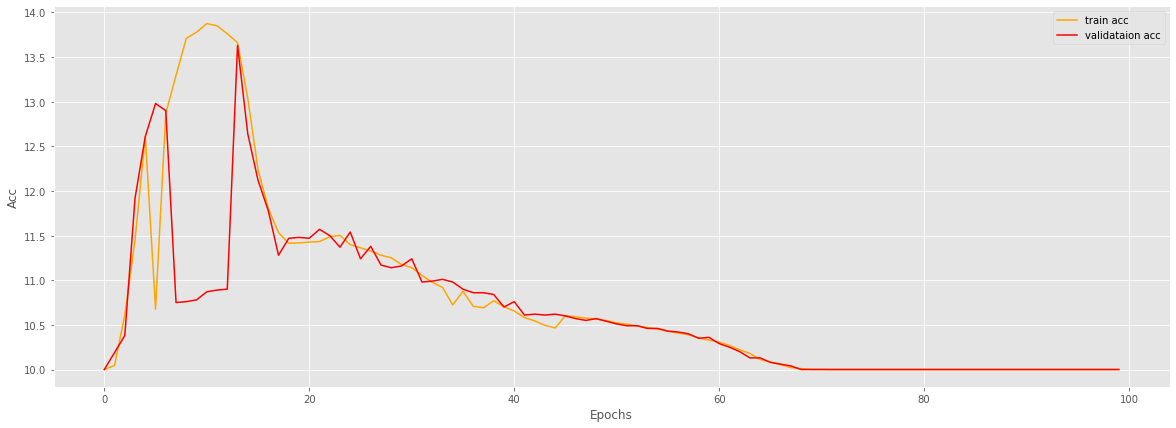

Max tr acc =  13.875
Max va acc =  13.63


In [16]:
tr_acc = result_df_tr_all.values[:,0].squeeze()
va_acc = result_df_va_all.values[:,0].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_acc, color='orange', label='train acc')
plt.plot(va_acc, color='red', label='validataion acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()
print("Max tr acc = ", np.max(tr_acc))
print("Max va acc = ", np.max(va_acc))

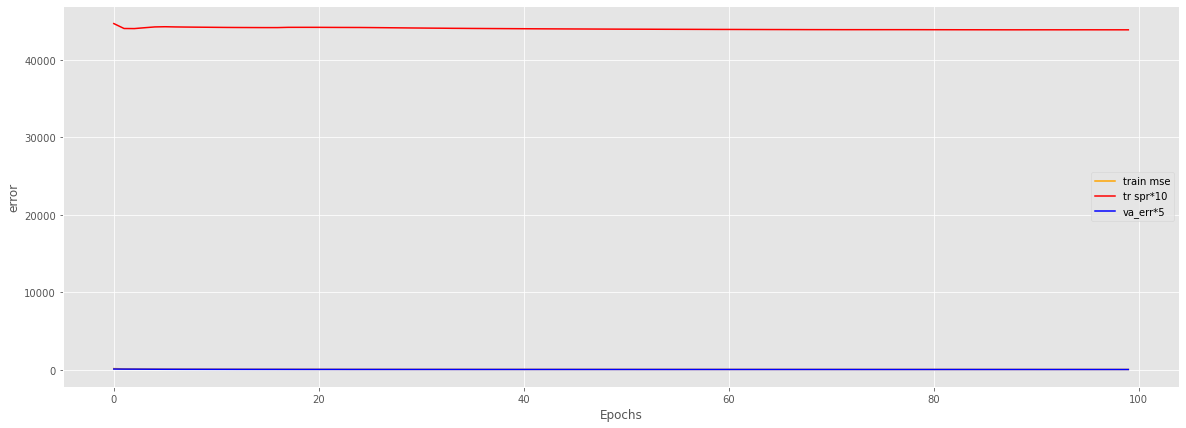

In [17]:
tr_mse = result_df_tr_all.values[:,3].squeeze()
tr_spr_50 = 10*result_df_tr_all.values[:,4].squeeze()
va_err = 5*result_df_va_all.values[:,-1].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_mse, color='orange', label='train mse')
plt.plot(tr_spr_50, color='red', label='tr spr*10')
plt.plot(va_err, color='blue', label='va_err*5')
plt.xlabel('Epochs')
plt.ylabel('error')
plt.legend()
plt.show()